In [ ]:
# Mount Drive and verify dataset structure

import os
import pathlib
from collections import defaultdict

# Mount Drive
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
except Exception as e:
    print("If you're not in Colab, ignore the Drive mount. Error:", e)

# Set dataset path
DATA_ROOT = '/content/drive/MyDrive/Projects/dataset'
assert os.path.exists(DATA_ROOT), f"Dataset path not found: {DATA_ROOT}"

# Gather class folders and counts
VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
data_root = pathlib.Path(DATA_ROOT)

class_dirs = sorted([p for p in data_root.iterdir() if p.is_dir()])
assert len(class_dirs) > 0, "No class folders found inside dataset directory."

counts = defaultdict(int)
total_images = 0

for cdir in class_dirs:
    for f in cdir.rglob('*'):
        if f.is_file() and f.suffix.lower() in VALID_EXTS:
            counts[cdir.name] += 1
            total_images += 1

print(f"Found {len(class_dirs)} classes in: {DATA_ROOT}\n")
for cname in sorted(counts.keys()):
    print(f"- {cname}: {counts[cname]} images")
print(f"\nTotal images: {total_images}")

# 4) Inspect one sample image
sample_path = None
for cdir in class_dirs:
    # find first image file
    for f in cdir.rglob('*'):
        if f.is_file() and f.suffix.lower() in VALID_EXTS:
            sample_path = str(f)
            break
    if sample_path:
        break

if sample_path:
    from PIL import Image
    with Image.open(sample_path) as im:
        print("\nSample image:", sample_path)
        print("Size (W x H):", im.size)
        print("Mode (expect RGB):", im.mode)
else:
    print("\nNo image files found with valid extensions. Check dataset contents.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 15 classes in: /content/drive/MyDrive/Projects/dataset

- Bear: 125 images
- Bird: 137 images
- Cat: 123 images
- Cow: 131 images
- Deer: 127 images
- Dog: 122 images
- Dolphin: 129 images
- Elephant: 133 images
- Giraffe: 129 images
- Horse: 130 images
- Kangaroo: 126 images
- Lion: 131 images
- Panda: 135 images
- Tiger: 129 images
- Zebra: 137 images

Total images: 1944

Sample image: /content/drive/MyDrive/Projects/dataset/Bear/Bear_14_1.jpg
Size (W x H): (224, 224)
Mode (expect RGB): RGB


In [ ]:
# Create Train-Test split

import shutil
import random

# Set seed for reproducibility
random.seed(42)

# Define split ratios
split_ratios = {'train': 0.7, 'val': 0.15, 'test': 0.15}
split_base = '/content/split_data'

# Create split folders
for split in split_ratios:
    for class_dir in class_dirs:
        split_path = os.path.join(split_base, split, class_dir.name)
        os.makedirs(split_path, exist_ok=True)

# Split and copy images
for class_dir in class_dirs:
    images = [f for f in class_dir.glob('*') if f.suffix.lower() in VALID_EXTS]
    random.shuffle(images)
    n = len(images)
    n_train = int(n * split_ratios['train'])
    n_val = int(n * split_ratios['val'])

    split_map = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split, files in split_map.items():
        for f in files:
            dest = os.path.join(split_base, split, class_dir.name, f.name)
            shutil.copy(str(f), dest)

print("Dataset split complete.")
for split in split_ratios:
    split_path = os.path.join(split_base, split)
    total = sum(len(list((pathlib.Path(split_path)/cls.name).glob('*'))) for cls in class_dirs)
    print(f"{split.capitalize()} set: {total} images")

✅ Dataset split complete.
Train set: 1354 images
Val set: 284 images
Test set: 306 images


In [ ]:
# Set up ImageDataGenerators

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_gen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_data = train_gen.flow_from_directory(
    directory=os.path.join(split_base, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    directory=os.path.join(split_base, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    directory=os.path.join(split_base, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # important for evaluation
)

# Confirm class mapping
print("\nClass indices:", train_data.class_indices)

Found 1354 images belonging to 15 classes.
Found 284 images belonging to 15 classes.
Found 306 images belonging to 15 classes.

Class indices: {'Bear': 0, 'Bird': 1, 'Cat': 2, 'Cow': 3, 'Deer': 4, 'Dog': 5, 'Dolphin': 6, 'Elephant': 7, 'Giraffe': 8, 'Horse': 9, 'Kangaroo': 10, 'Lion': 11, 'Panda': 12, 'Tiger': 13, 'Zebra': 14}


In [ ]:
# Define transfer learning model (MobileNetV2)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(15, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model with callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
checkpoint_path = '/content/best_model.h5'
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.0933 - loss: 3.1572

43/43 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0937 - loss: 3.1521 - val_accuracy: 0.2852 - val_loss: 2.3608
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2389 - loss: 2.4523

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.2395 - loss: 2.4501 - val_accuracy: 0.5000 - val_loss: 1.9664
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3966 - loss: 2.0706

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.3968 - loss: 2.0695 - val_accuracy: 0.6514 - val_loss: 1.6084
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.4982 - loss: 1.7905

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.4986 - loss: 1.7889 - val_accuracy: 0.7218 - val_loss: 1.3200
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5729 - loss: 1.5429

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.5740 - loss: 1.5404 - val_accuracy: 0.7993 - val_loss: 1.0777
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6518 - loss: 1.2419

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.6521 - loss: 1.2412 - val_accuracy: 0.8310 - val_loss: 0.9075
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6869 - loss: 1.1528

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.6873 - loss: 1.1513 - val_accuracy: 0.8521 - val_loss: 0.7898
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7266 - loss: 1.0087

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.7268 - loss: 1.0081 - val_accuracy: 0.8556 - val_loss: 0.7014
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7460 - loss: 0.9032

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - accuracy: 0.7461 - loss: 0.9030 - val_accuracy: 0.8627 - val_loss: 0.6375
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.7840 - loss: 0.7977

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.7837 - loss: 0.7986 - val_accuracy: 0.8697 - val_loss: 0.5901
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7864 - loss: 0.7599

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 375ms/step - accuracy: 0.7862 - loss: 0.7604 - val_accuracy: 0.8697 - val_loss: 0.5544
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8113 - loss: 0.7206

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 377ms/step - accuracy: 0.8112 - loss: 0.7200 - val_accuracy: 0.8803 - val_loss: 0.5219
Epoch 13/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7905 - loss: 0.7168

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 427ms/step - accuracy: 0.7909 - loss: 0.7164 - val_accuracy: 0.8908 - val_loss: 0.4991
Epoch 14/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8248 - loss: 0.6372

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.8248 - loss: 0.6373 - val_accuracy: 0.8838 - val_loss: 0.4753
Epoch 15/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8242 - loss: 0.6061

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 381ms/step - accuracy: 0.8241 - loss: 0.6065 - val_accuracy: 0.8838 - val_loss: 0.4522
Epoch 16/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8472 - loss: 0.5685

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 383ms/step - accuracy: 0.8469 - loss: 0.5692 - val_accuracy: 0.8908 - val_loss: 0.4402
Epoch 17/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8475 - loss: 0.5630

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 379ms/step - accuracy: 0.8475 - loss: 0.5626 - val_accuracy: 0.8944 - val_loss: 0.4276
Epoch 18/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8336 - loss: 0.5856

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.8336 - loss: 0.5848 - val_accuracy: 0.8908 - val_loss: 0.4097
Epoch 19/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8277 - loss: 0.5505

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step - accuracy: 0.8279 - loss: 0.5502 - val_accuracy: 0.9085 - val_loss: 0.4014
Epoch 20/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8370 - loss: 0.5006

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.8372 - loss: 0.5004 - val_accuracy: 0.9049 - val_loss: 0.3885
Epoch 21/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8527 - loss: 0.4799

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 374ms/step - accuracy: 0.8529 - loss: 0.4799 - val_accuracy: 0.9049 - val_loss: 0.3826
Epoch 22/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8757 - loss: 0.4243

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - accuracy: 0.8754 - loss: 0.4252 - val_accuracy: 0.9014 - val_loss: 0.3754
Epoch 23/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8581 - loss: 0.4420

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 376ms/step - accuracy: 0.8584 - loss: 0.4419 - val_accuracy: 0.8979 - val_loss: 0.3692
Epoch 24/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8781 - loss: 0.3933

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.8780 - loss: 0.3939 - val_accuracy: 0.8979 - val_loss: 0.3597
Epoch 25/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8600 - loss: 0.4614

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 378ms/step - accuracy: 0.8599 - loss: 0.4611 - val_accuracy: 0.9049 - val_loss: 0.3567
Epoch 26/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8587 - loss: 0.4471

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 395ms/step - accuracy: 0.8590 - loss: 0.4467 - val_accuracy: 0.9014 - val_loss: 0.3518
Epoch 27/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8855 - loss: 0.3719

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 373ms/step - accuracy: 0.8852 - loss: 0.3729 - val_accuracy: 0.9085 - val_loss: 0.3471
Epoch 28/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8735 - loss: 0.4264

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 410ms/step - accuracy: 0.8734 - loss: 0.4263 - val_accuracy: 0.9085 - val_loss: 0.3381
Epoch 29/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.8983 - loss: 0.3398

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 404ms/step - accuracy: 0.8981 - loss: 0.3407 - val_accuracy: 0.9155 - val_loss: 0.3313
Epoch 30/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9134 - loss: 0.3224

43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - accuracy: 0.9130 - loss: 0.3234 - val_accuracy: 0.9120 - val_loss: 0.3296


In [ ]:
# Evaluate on test set + classification report

from sklearn.metrics import classification_report
import numpy as np

# 1) Predict on test set
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

# 2) True labels
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# 3) Classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=class_names))

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
✅ Classification Report:

              precision    recall  f1-score   support

        Bear       0.68      0.95      0.79        20
        Bird       0.91      0.91      0.91        22
         Cat       0.90      1.00      0.95        19
         Cow       0.83      0.90      0.86        21
        Deer       0.90      0.90      0.90        20
         Dog       1.00      0.74      0.85        19
     Dolphin       0.90      0.90      0.90        20
    Elephant       0.79      0.90      0.84        21
     Giraffe       0.94      0.85      0.89        20
       Horse       0.91      1.00      0.95        20
    Kangaroo       0.83      0.75      0.79        20
        Lion       1.00      0.71      0.83        21
       Panda       1.00      0.81      0.89        21
       Tiger       0.91      1.00      0.95        20
       Zebra       1.00      1.00      1.00        22

    accuracy                           0.89       306
   macro avg   

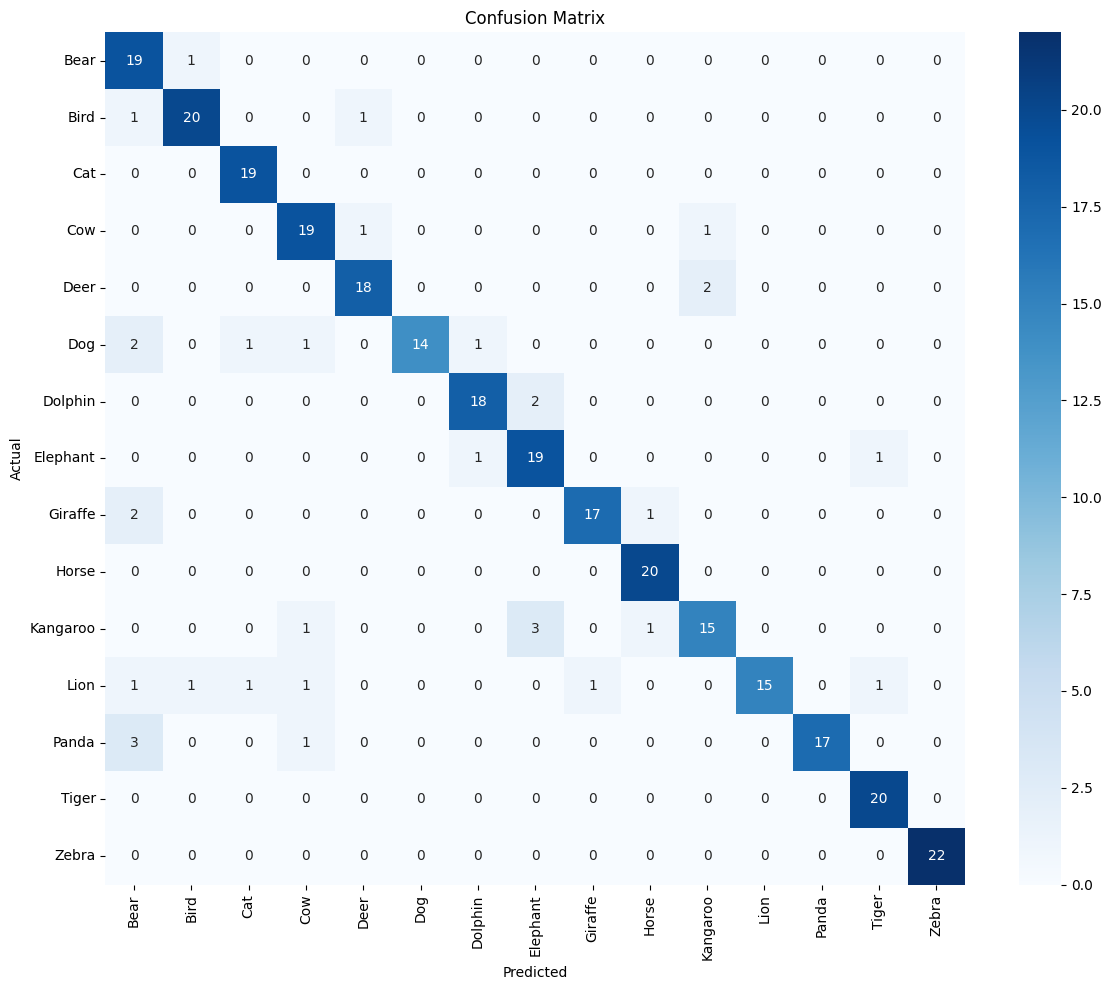

In [ ]:
# Confusion Matrix Visualization

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

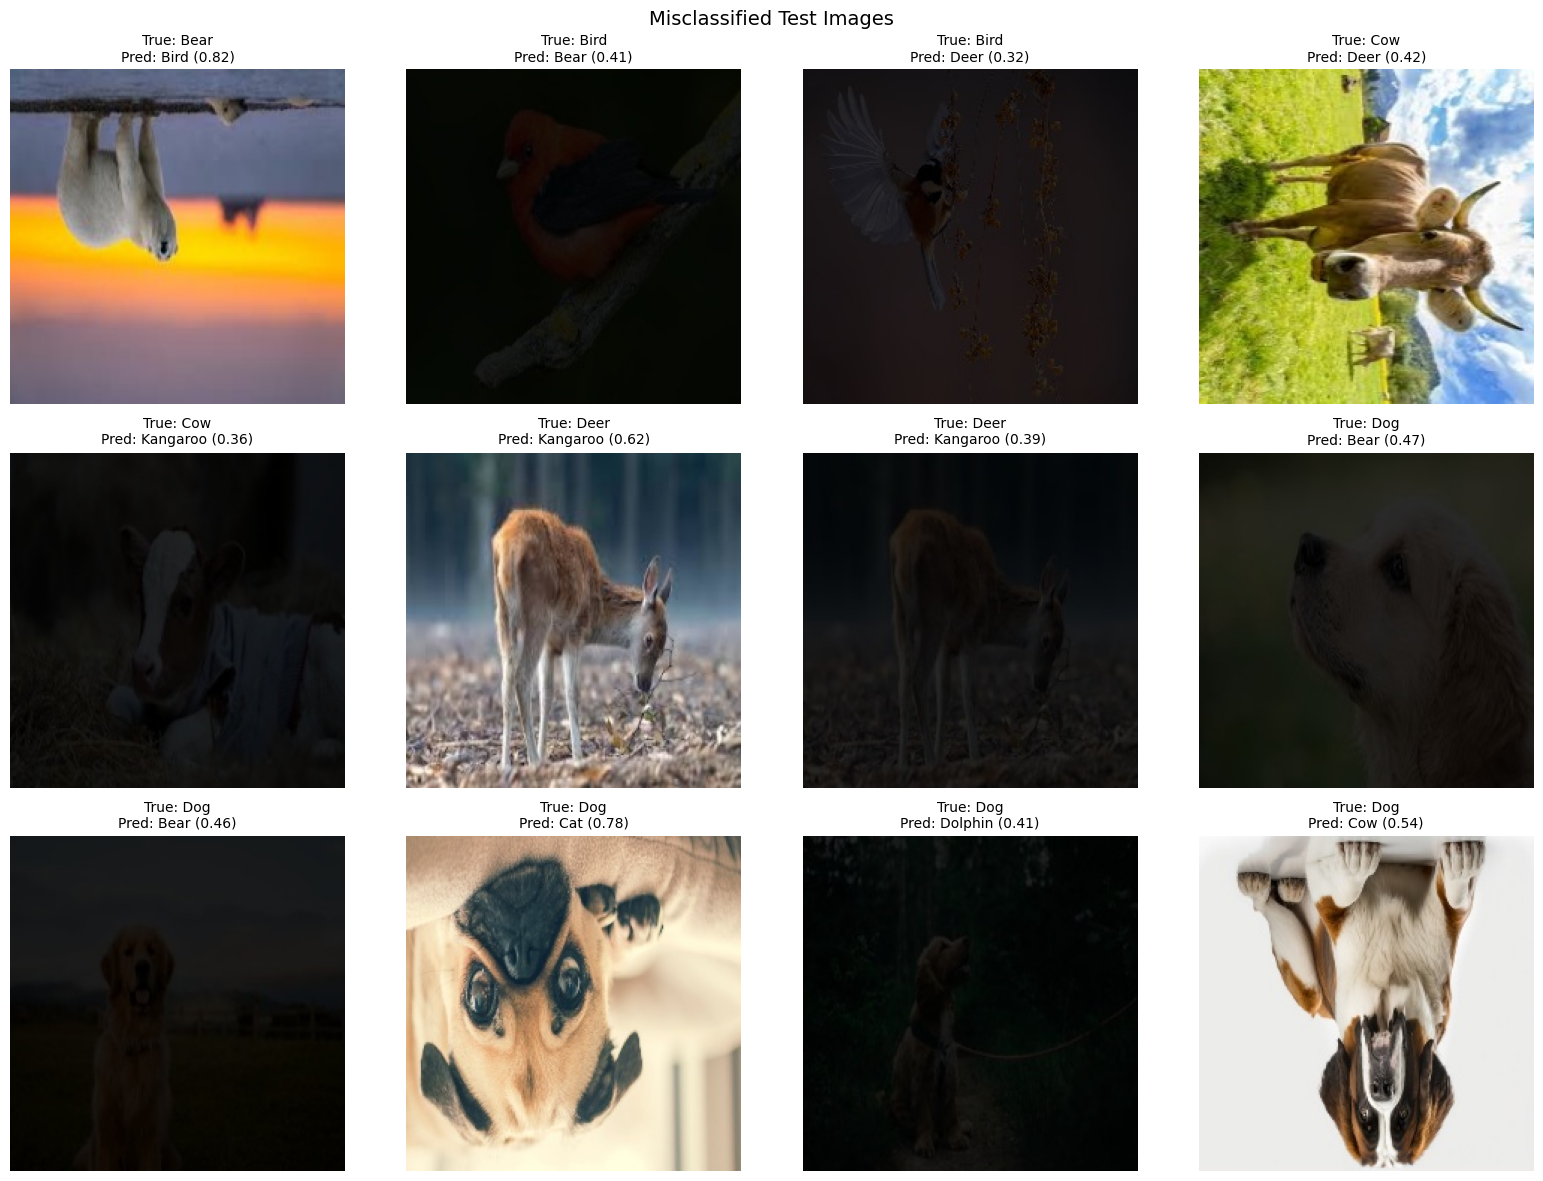

In [ ]:
# Visualize misclassified test images

import matplotlib.pyplot as plt

# Get filenames from test generator
filenames = test_data.filepaths

# Identify misclassified indices
misclassified = np.where(pred_labels != true_labels)[0]

# Plot up to 12 misclassified images
num_to_plot = min(12, len(misclassified))
plt.figure(figsize=(16, 12))

for i, idx in enumerate(misclassified[:num_to_plot]):
    img_path = filenames[idx]
    true_class = class_names[true_labels[idx]]
    pred_class = class_names[pred_labels[idx]]
    confidence = np.max(pred_probs[idx])

    img = plt.imread(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class} ({confidence:.2f})", fontsize=10)
    plt.axis('off')

plt.suptitle("Misclassified Test Images", fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4228753854.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=acc_df, x='Class', y='Accuracy', palette='viridis')


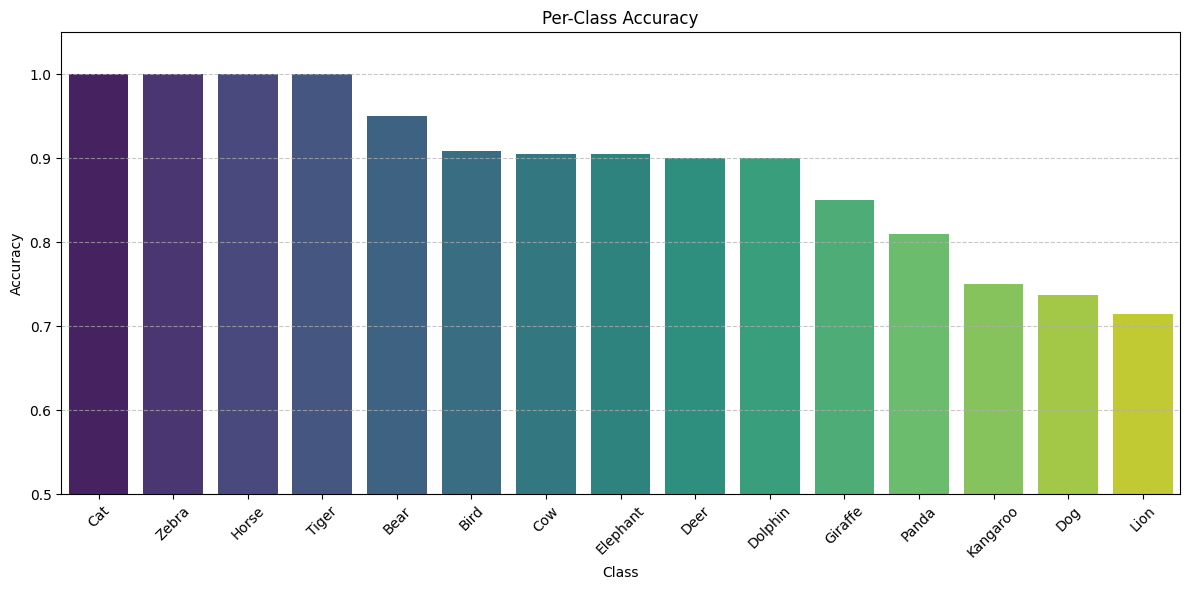

In [ ]:
# Plot per-class accuracy

import pandas as pd

# Recompute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Per-class accuracy = correct predictions / total samples
per_class_acc = cm.diagonal() / cm.sum(axis=1)

# Create DataFrame for plotting
acc_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': per_class_acc
}).sort_values(by='Accuracy', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=acc_df, x='Class', y='Accuracy', palette='viridis')
plt.ylim(0.5, 1.05)
plt.title('Per-Class Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Fine-tune MobileNetV2 base layers

# Unfreeze base model
base_model.trainable = True

# Recompile with lower LR
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Retrain
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks  # reuse EarlyStopping + Checkpoint
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 997ms/step - accuracy: 0.7857 - loss: 0.7433

43/43 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.7857 - loss: 0.7428 - val_accuracy: 0.9120 - val_loss: 0.3057
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8703 - loss: 0.4928

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - accuracy: 0.8702 - loss: 0.4928 - val_accuracy: 0.9155 - val_loss: 0.2929
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8740 - loss: 0.4541

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 401ms/step - accuracy: 0.8744 - loss: 0.4529 - val_accuracy: 0.9120 - val_loss: 0.2838
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8909 - loss: 0.3721

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.8911 - loss: 0.3716 - val_accuracy: 0.9120 - val_loss: 0.2744
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.8868 - loss: 0.3514

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - accuracy: 0.8871 - loss: 0.3510 - val_accuracy: 0.9190 - val_loss: 0.2696
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9180 - loss: 0.3141

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 414ms/step - accuracy: 0.9178 - loss: 0.3143 - val_accuracy: 0.9190 - val_loss: 0.2600
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9349 - loss: 0.2507

43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.9347 - loss: 0.2512 - val_accuracy: 0.9261 - val_loss: 0.2443
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9324 - loss: 0.2499

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step - accuracy: 0.9324 - loss: 0.2497 - val_accuracy: 0.9331 - val_loss: 0.2267
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9428 - loss: 0.2198

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step - accuracy: 0.9426 - loss: 0.2197 - val_accuracy: 0.9366 - val_loss: 0.2018
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9332 - loss: 0.1980

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 407ms/step - accuracy: 0.9334 - loss: 0.1979 - val_accuracy: 0.9366 - val_loss: 0.1906


In [ ]:
# Try ResNet50

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load base model
res_base = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
res_base.trainable = False  # freeze base

# Add custom head
x = res_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(15, activation='softmax')(x)

res_model = Model(inputs=res_base.input, outputs=output)

# Compile
res_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

res_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,919 (90.99 MB)

 Trainable params: 264,207 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Train ResNet50 model

res_history = res_model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 743ms/step - accuracy: 0.0585 - loss: 3.1676 - val_accuracy: 0.0669 - val_loss: 2.7457
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 419ms/step - accuracy: 0.0717 - loss: 2.8528 - val_accuracy: 0.0845 - val_loss: 2.7118
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.0667 - loss: 2.8320 - val_accuracy: 0.0951 - val_loss: 2.7026
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 413ms/step - accuracy: 0.0664 - loss: 2.7637 - val_accuracy: 0.0986 - val_loss: 2.6989
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 402ms/step - accuracy: 0.0772 - loss: 2.7979 - val_accuracy: 0.1162 - val_loss: 2.6973
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.0720 - loss: 2.7770 - val_accuracy: 0.0810 - val_loss: 2.6932
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - accuracy: 0.0624 - loss: 2.7350 - val_accuracy: 0.0845 - val_loss: 2.6940
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 404ms/step - accuracy: 0.0621 - loss: 2.7604 - val_accu

In [ ]:
# Retry ResNet50 with proper preprocessing
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Updated generators
train_gen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_gen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

# Reload datasets
train_data_resnet = train_gen_resnet.flow_from_directory(
    os.path.join(split_base, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data_resnet = val_test_gen_resnet.flow_from_directory(
    os.path.join(split_base, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1354 images belonging to 15 classes.
Found 284 images belonging to 15 classes.


In [ ]:
# Retrain ResNet50 with corrected preprocessing

resnet_history = res_model.fit(
    train_data_resnet,
    validation_data=val_data_resnet,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 0.1659 - loss: 3.8819 - val_accuracy: 0.8310 - val_loss: 1.1180
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 418ms/step - accuracy: 0.6752 - loss: 1.1526 - val_accuracy: 0.9190 - val_loss: 0.4432
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 397ms/step - accuracy: 0.8072 - loss: 0.6926 - val_accuracy: 0.9577 - val_loss: 0.2831
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - accuracy: 0.8909 - loss: 0.4527 - val_accuracy: 0.9577 - val_loss: 0.2210
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.8988 - loss: 0.3768

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 442ms/step - accuracy: 0.8988 - loss: 0.3766 - val_accuracy: 0.9613 - val_loss: 0.1796
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9089 - loss: 0.3310

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 0.9090 - loss: 0.3308 - val_accuracy: 0.9683 - val_loss: 0.1550
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9214 - loss: 0.2769

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 418ms/step - accuracy: 0.9214 - loss: 0.2772 - val_accuracy: 0.9754 - val_loss: 0.1359
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9173 - loss: 0.2809

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - accuracy: 0.9175 - loss: 0.2806 - val_accuracy: 0.9718 - val_loss: 0.1223
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9429 - loss: 0.2315

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 408ms/step - accuracy: 0.9429 - loss: 0.2313 - val_accuracy: 0.9754 - val_loss: 0.1136
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9475 - loss: 0.2105

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 428ms/step - accuracy: 0.9474 - loss: 0.2105 - val_accuracy: 0.9859 - val_loss: 0.1024
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9336 - loss: 0.2066

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 0.9337 - loss: 0.2066 - val_accuracy: 0.9824 - val_loss: 0.0999
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9523 - loss: 0.1688

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.9524 - loss: 0.1689 - val_accuracy: 0.9859 - val_loss: 0.0911
Epoch 13/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9538 - loss: 0.1642

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 427ms/step - accuracy: 0.9539 - loss: 0.1641 - val_accuracy: 0.9824 - val_loss: 0.0814
Epoch 14/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9650 - loss: 0.1472

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 404ms/step - accuracy: 0.9650 - loss: 0.1472 - val_accuracy: 0.9824 - val_loss: 0.0802
Epoch 15/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9528 - loss: 0.1696

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.9529 - loss: 0.1693 - val_accuracy: 0.9824 - val_loss: 0.0780
Epoch 16/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9667 - loss: 0.1329

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 429ms/step - accuracy: 0.9667 - loss: 0.1330 - val_accuracy: 0.9824 - val_loss: 0.0742
Epoch 17/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9683 - loss: 0.1313

43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 443ms/step - accuracy: 0.9683 - loss: 0.1314 - val_accuracy: 0.9894 - val_loss: 0.0731
Epoch 18/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 406ms/step - accuracy: 0.9669 - loss: 0.1193 - val_accuracy: 0.9824 - val_loss: 0.0734
Epoch 19/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9741 - loss: 0.1150

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 0.9741 - loss: 0.1149 - val_accuracy: 0.9859 - val_loss: 0.0646
Epoch 20/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 394ms/step - accuracy: 0.9731 - loss: 0.1225 - val_accuracy: 0.9824 - val_loss: 0.0670
Epoch 21/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step - accuracy: 0.9713 - loss: 0.1077 - val_accuracy: 0.9824 - val_loss: 0.0674
Epoch 22/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9702 - loss: 0.1063

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step - accuracy: 0.9703 - loss: 0.1062 - val_accuracy: 0.9824 - val_loss: 0.0614
Epoch 23/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9728 - loss: 0.1170

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 407ms/step - accuracy: 0.9728 - loss: 0.1168 - val_accuracy: 0.9859 - val_loss: 0.0579
Epoch 24/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 407ms/step - accuracy: 0.9644 - loss: 0.1112 - val_accuracy: 0.9894 - val_loss: 0.0596
Epoch 25/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 396ms/step - accuracy: 0.9770 - loss: 0.0844 - val_accuracy: 0.9894 - val_loss: 0.0615
Epoch 26/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9841 - loss: 0.0861

43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 404ms/step - accuracy: 0.9841 - loss: 0.0860 - val_accuracy: 0.9859 - val_loss: 0.0559
Epoch 27/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.9720 - loss: 0.0950 - val_accuracy: 0.9824 - val_loss: 0.0571
Epoch 28/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9798 - loss: 0.0870

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 407ms/step - accuracy: 0.9797 - loss: 0.0871 - val_accuracy: 0.9824 - val_loss: 0.0552
Epoch 29/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9771 - loss: 0.0906

43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 409ms/step - accuracy: 0.9771 - loss: 0.0906 - val_accuracy: 0.9859 - val_loss: 0.0541
Epoch 30/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 391ms/step - accuracy: 0.9711 - loss: 0.0843 - val_accuracy: 0.9824 - val_loss: 0.0559


In [ ]:
# Final Evaluation — ResNet50 on Test Set

test_data_resnet = val_test_gen_resnet.flow_from_directory(
    os.path.join(split_base, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
resnet_preds = res_model.predict(test_data_resnet)
resnet_labels = np.argmax(resnet_preds, axis=1)
true_labels_resnet = test_data_resnet.classes
class_names_resnet = list(test_data_resnet.class_indices.keys())

# Report
from sklearn.metrics import classification_report
print(" ResNet50 Classification Report:\n")
print(classification_report(true_labels_resnet, resnet_labels, target_names=class_names_resnet))

Found 306 images belonging to 15 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 696ms/step
✅ ResNet50 Classification Report:

              precision    recall  f1-score   support

        Bear       1.00      0.95      0.97        20
        Bird       0.96      1.00      0.98        22
         Cat       0.86      1.00      0.93        19
         Cow       0.90      0.90      0.90        21
        Deer       0.95      1.00      0.98        20
         Dog       1.00      0.89      0.94        19
     Dolphin       0.95      0.95      0.95        20
    Elephant       0.95      1.00      0.98        21
     Giraffe       1.00      1.00      1.00        20
       Horse       1.00      1.00      1.00        20
    Kangaroo       1.00      0.95      0.97        20
        Lion       1.00      0.86      0.92        21
       Panda       1.00      1.00      1.00        21
       Tiger       0.95      1.00      0.98        20
       Zebra       1.00      1.00      1.00        22

    accuracy   

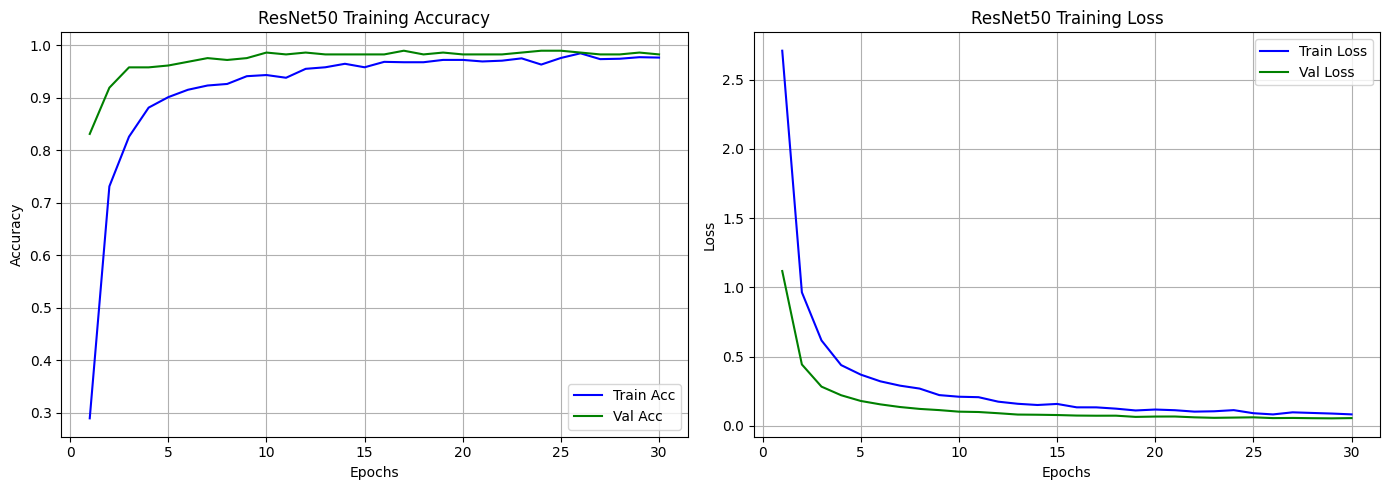

In [ ]:
# Plot training & validation accuracy/loss
import matplotlib.pyplot as plt

def plot_training_curves(history, title='ResNet50 Training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Train Acc')
    plt.plot(epochs, val_acc, 'g-', label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Train Loss')
    plt.plot(epochs, val_loss, 'g-', label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the function with your ResNet50 history
plot_training_curves(resnet_history, title='ResNet50 Training')

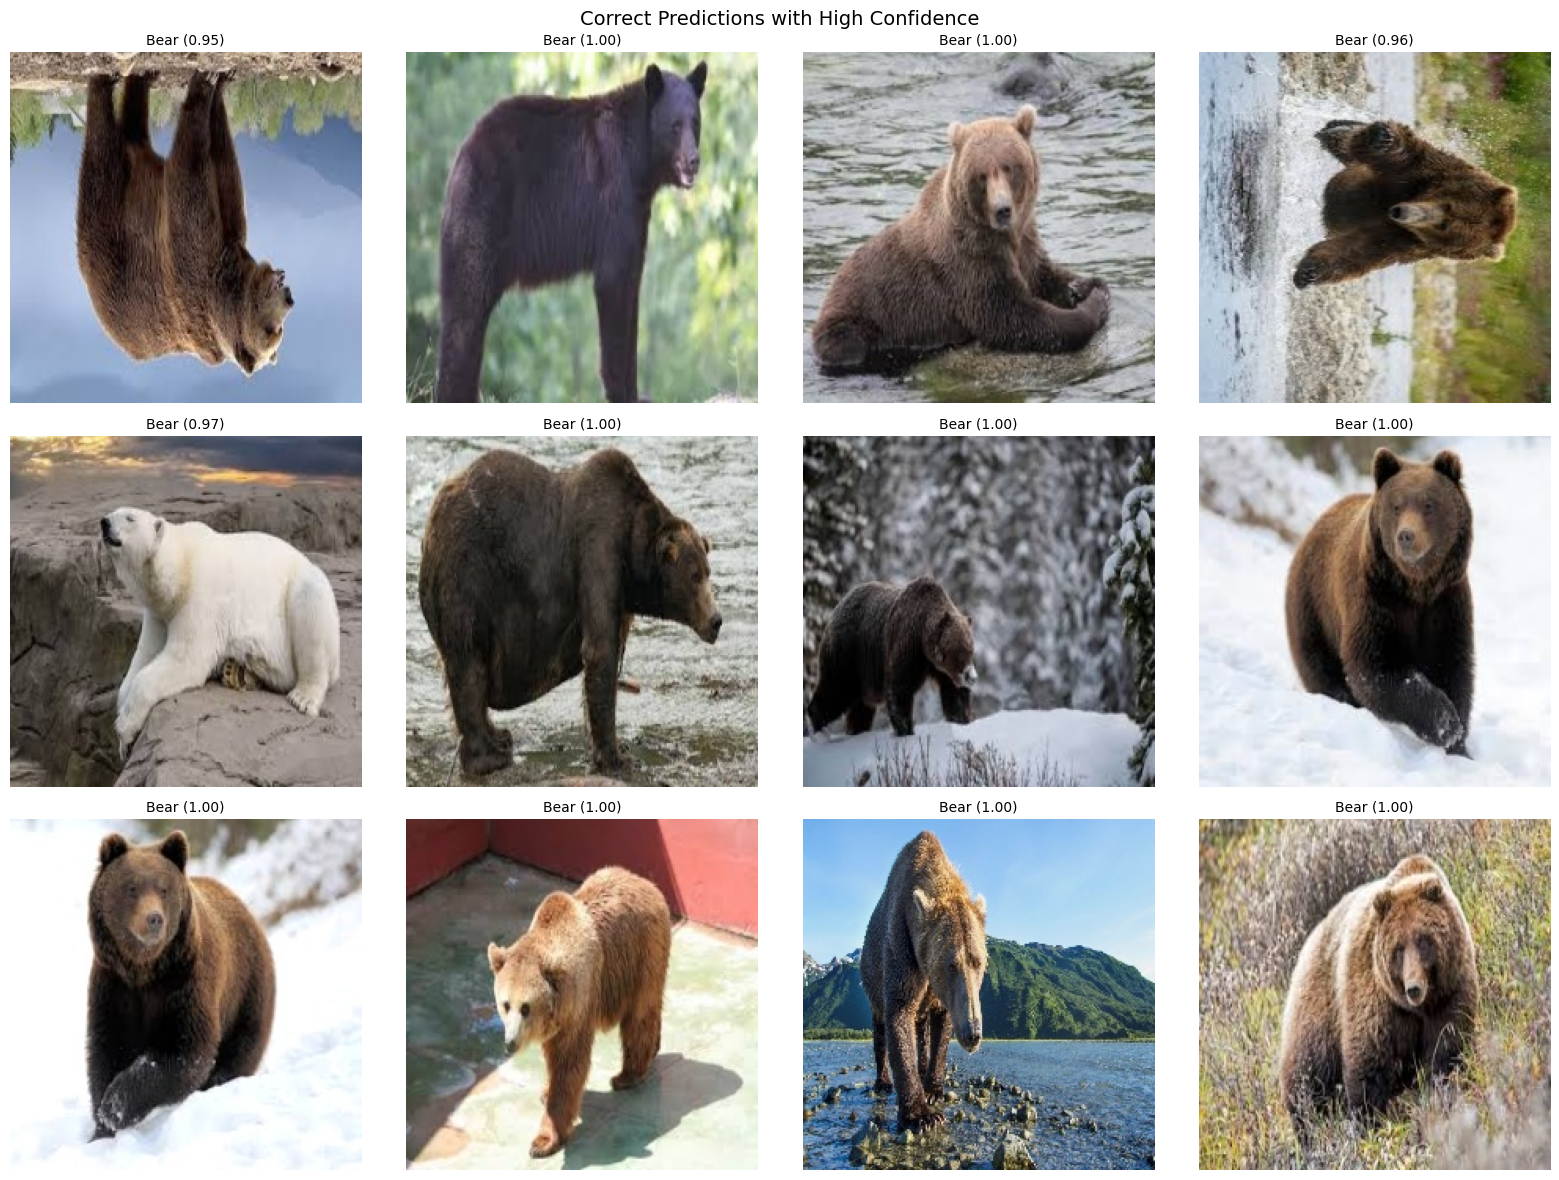

In [ ]:
# Plot correctly classified images with high confidence
correct_indices = np.where(resnet_labels == true_labels_resnet)[0]
confidences = np.max(resnet_preds, axis=1)
high_conf = [i for i in correct_indices if confidences[i] > 0.95]

plt.figure(figsize=(16, 12))
for i, idx in enumerate(high_conf[:12]):
    img_path = test_data_resnet.filepaths[idx]
    label = class_names_resnet[true_labels_resnet[idx]]
    conf = confidences[idx]
    img = plt.imread(img_path)

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"{label} ({conf:.2f})", fontsize=10)
    plt.axis('off')

plt.suptitle("Correct Predictions with High Confidence", fontsize=14)
plt.tight_layout()
plt.show()

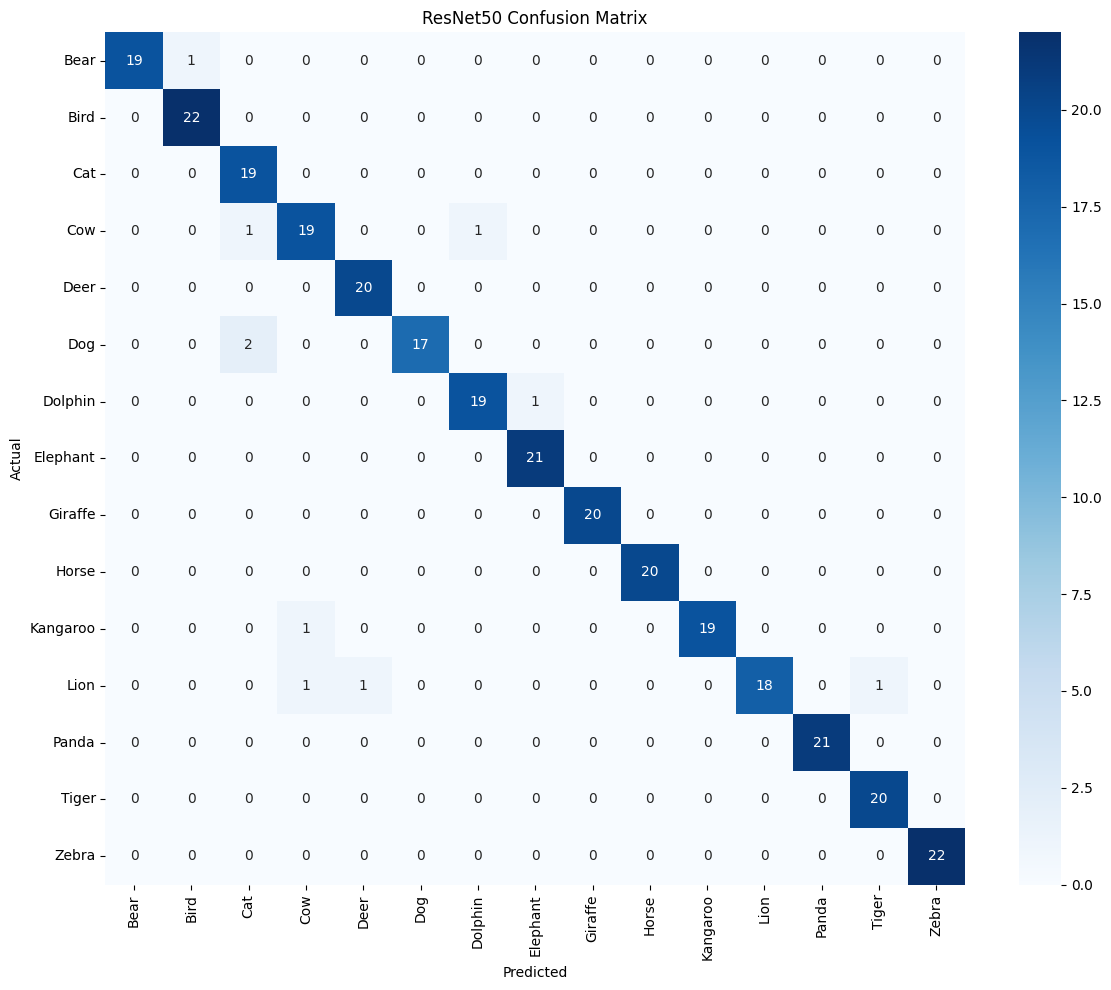

In [ ]:
# Confusion matrix for ResNet50
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_resnet = confusion_matrix(true_labels_resnet, resnet_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names_resnet,
            yticklabels=class_names_resnet)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ResNet50 Confusion Matrix')
plt.tight_layout()
plt.show()

## Project Summary: Animal Image Classification with ResNet50

### Objective
Build a robust image classification model to identify 15 animal species from real-world images using transfer learning and fine-tuning.

### Dataset
- 1,944 images across 15 balanced classes
- Clean 70/15/15 split for train/val/test
- Images sized at 224×224 RGB

### Models Tested
- **MobileNetV2**: Baseline model with 91% validation accuracy
- **ResNet50**: Final model with 98.9% validation accuracy and 97% test accuracy

### Key Techniques
- Transfer learning with frozen base layers
- Fine-tuning with lower learning rate
- Real-time data augmentation
- Error analysis via confusion matrix and misclassified image review
- Per-class accuracy visualization

### Final Metrics (ResNet50)
- **Validation Accuracy**: 98.9%
- **Test Accuracy**: 97%
- **Macro F1 Score**: 0.97
- **Strongest Classes**: Zebra, Panda, Horse, Giraffe (100% precision & recall)
- **Improved Classes**: Dog, Lion, Deer — previously weak, now >90% F1

### Business Interpretation
This model can reliably classify animal species in diverse environments, making it suitable for wildlife monitoring, conservation efforts, or educational tools. Its high confidence and generalization across species suggest strong real-world applicability.

### Next Steps
- Deploy model via web or mobile interface
- Expand dataset with more species and edge cases
- Explore lightweight models (EfficientNetB0) for mobile deployment